<a href="https://colab.research.google.com/github/Sirilak-1447/229352-StatisticalLearning/blob/main/660510777_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [38]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [39]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [40]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [41]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [42]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [43]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [44]:
train_loader

In [45]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


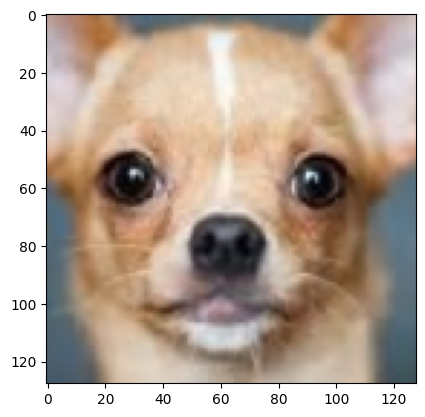

In [46]:
plt.imshow(X[0].numpy().transpose(1, 2, 0))

#### Visualize the first four images in the batch

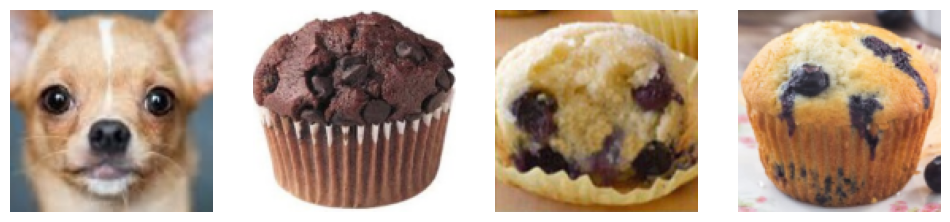

tensor([0, 1, 1, 1])


In [47]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [48]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 128 * 3, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.sigmoid(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [49]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [50]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [51]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [52]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [53]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [54]:
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [55]:
y_hat = model(X)
print(y_hat.shape)
print(y.shape)

y_hat = y_hat[:, 0]
y = y.to(torch.float32)

torch.Size([10, 1])
torch.Size([10])


#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [56]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [57]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss_backward = loss.backward()

In [58]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [59]:
for param in model.parameters():
  print(param.grad)

tensor([[ 4.0196e-02,  4.6471e-02,  4.9216e-02,  ...,  1.3725e-03,
         -4.3272e-09, -1.6275e-02]])
tensor([0.1000])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [60]:
# Manually update the weights using the gradient descent rule

with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [61]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [62]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.6892507672309875]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

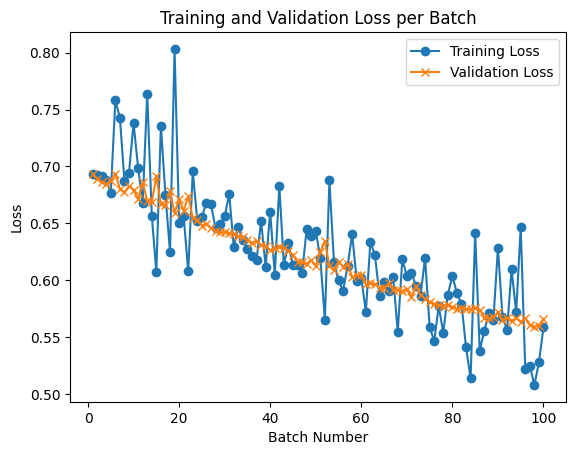

In [63]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [64]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


**1.Create a neural network with 3 hidden layers as shown in the picture**

In [65]:
class NeuralNetworkWithThreeHiddenLayers(nn.Module):
    def __init__(self):
        super(NeuralNetworkWithThreeHiddenLayers, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128 * 128 * 3, 128)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)  # Third hidden layer
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(32, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

**2.Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5**

In [66]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
all_train_losses = {}
all_val_losses = {}
trained_models = {} # Dictionary to store trained models
num_epochs = 10

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = NeuralNetworkWithThreeHiddenLayers()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr) # Using SGD as an example optimizer

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                y_hat = y_hat[:, 0]
                y = y.to(torch.float32)
                val_loss = criterion(y_hat, y)
                val_losses.append(val_loss.item()) # Append item to store numeric value

    all_train_losses[lr] = train_losses
    all_val_losses[lr] = val_losses
    trained_models[lr] = model # Store the trained model

Training with learning rate: 0.01
Training with learning rate: 0.001
Training with learning rate: 0.0001
Training with learning rate: 1e-05


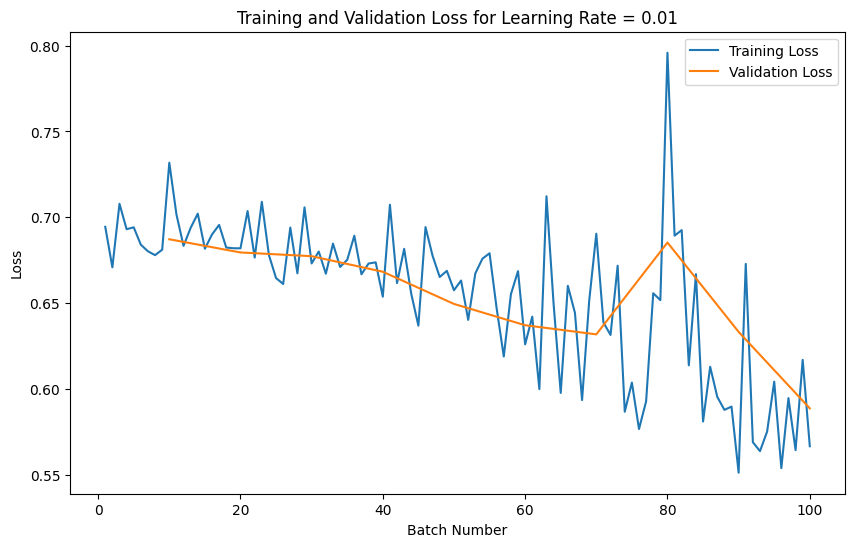

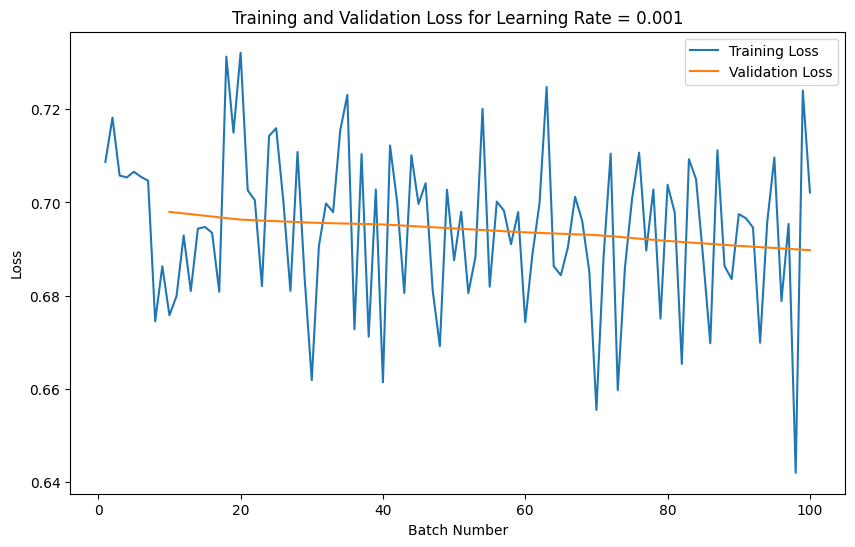

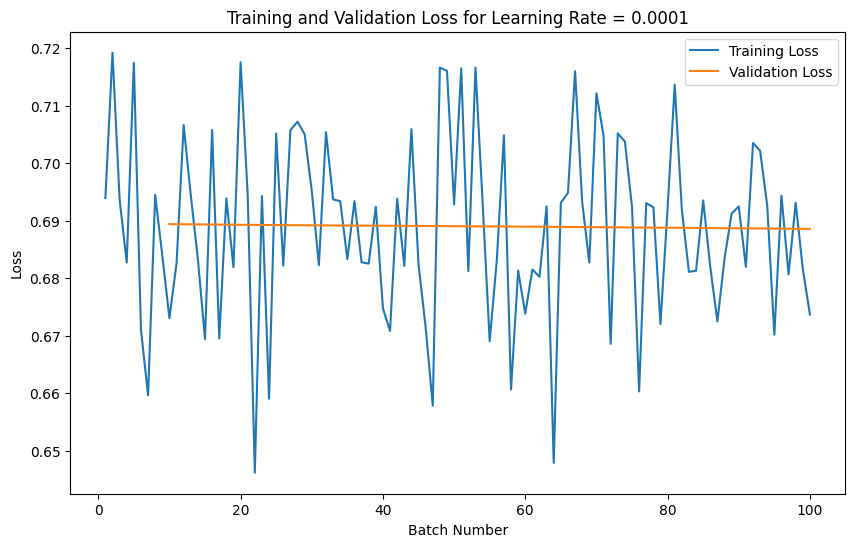

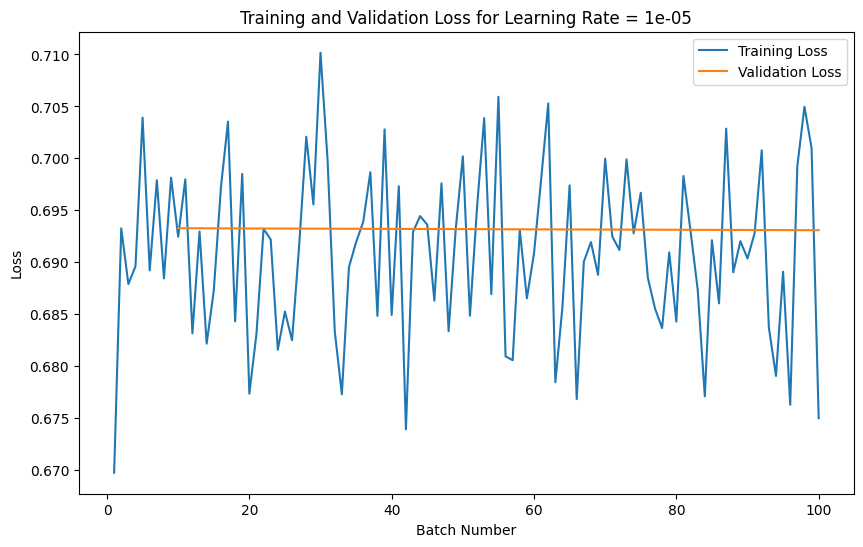

In [67]:
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(all_train_losses[lr])+1), all_train_losses[lr], label='Training Loss')
    # Validation loss is recorded once per epoch, so the x-axis should correspond to epochs
    plt.plot([i * len(train_loader) for i in range(1, len(all_val_losses[lr]) + 1)], all_val_losses[lr], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Learning Rate = {lr}')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**2.1 What value of learning rate do you think is the best? Please explain your reason**

**ตอบ** ดีที่สุด = 1e-3 จากการลดลงอย่างต่อเนื่องและกราฟลดลงนิ่งและ converge ดี


**2.2 What happens to the training losses if your learning rate is too large?**

**ตอบ** ถ้า LR ใหญ่เกินไป ทำให้ lossแกว่งตัวอย่างรุนแรงหรืออาจจะไม่ลดลงเลย (diverge) เพราะก้าวยาวจน overshoot

**2.3 What happens to the training losses if your learning rate is too small?**

**ตอบ** ถ้า LR เล็กเกินไป ทำให้loss ลดช้ามาก ก้าวของ gradient descent เล็กเกินไป อาจติดอยู่กับ local minimum หรือ plateau

**3.After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below**

In [68]:
# Use this code to calculate test accuracy
model.eval() # Set the model to evaluation mode
correct_predictions = 0
total_samples = 0

with torch.no_grad():
  for X, y in test_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y_hat = (y_hat > 0.5).float()  # the predictions

    correct_predictions += (y_hat == y).sum().item()
    total_samples += y.size(0)

accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5667


**4.Use plt.imshow() to display at least four images that are incorrectly classified by this model**

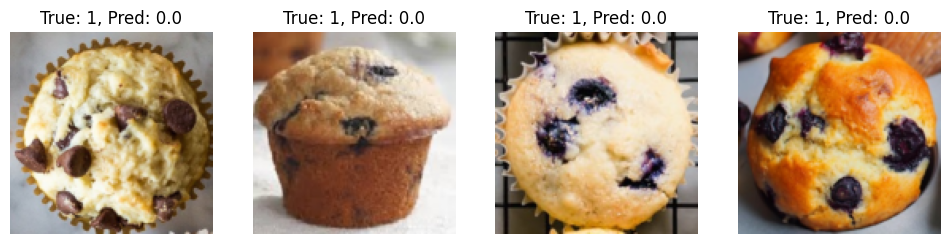

In [69]:
misclassified_images = []
misclassified_labels = []
predicted_labels = []

with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        predicted = (y_hat > 0.5).float()

        incorrect_indices = (predicted != y).nonzero(as_tuple=True)[0]

        for i in incorrect_indices:
            if len(misclassified_images) < 4:
                misclassified_images.append(X[i].cpu().numpy().transpose(1, 2, 0))
                misclassified_labels.append(y[i].item())
                predicted_labels.append(predicted[i].item())
            else:
                break
        if len(misclassified_images) >= 4:
            break

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(12, 4))
for i, img in enumerate(misclassified_images):
    axes[i].imshow(img)
    axes[i].set_title(f"True: {misclassified_labels[i]}, Pred: {predicted_labels[i]}")
    axes[i].axis('off')
plt.show()